Importing World3 as Network


In [105]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from collections import defaultdict
from cdlib import algorithms
from cdlib import evaluation
from matplotlib.lines import Line2D

# Load the JSON data
json_file = open('world3-03_variables.json')
w3_vars = json.loads(json_file.read())
json_file.close()

# Create directed graph
G = nx.DiGraph()
for name, val in w3_vars.items():
    G.add_node(name, var_type=val['type'])
    if val['dependencies'] is not None:
        G.add_edges_from([(dep, name) for dep in val['dependencies']])

Finding communities and modularity using Louvain algorithm

Modularity (Louvain): 0.6933


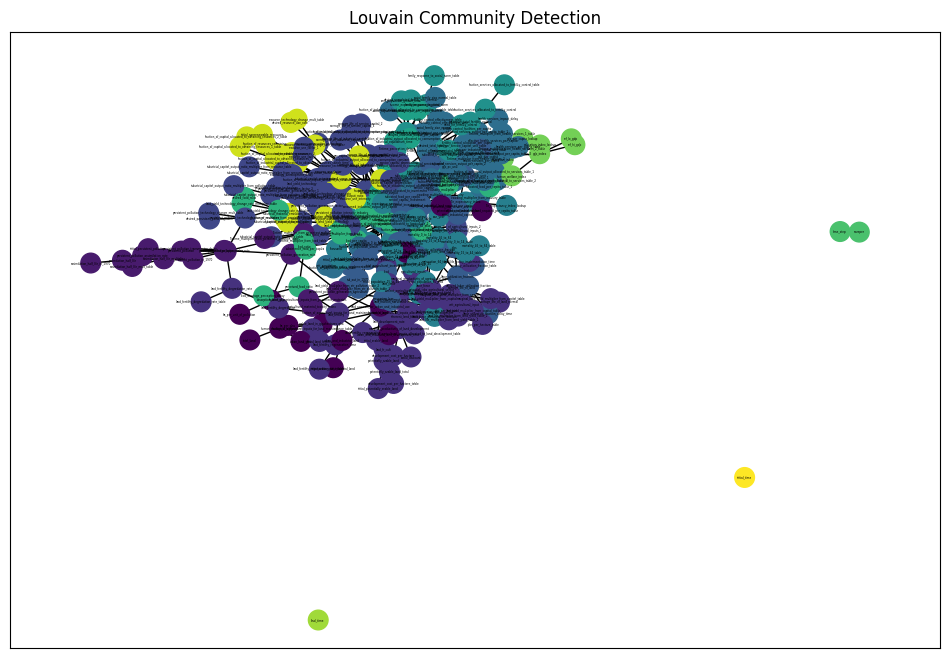

In [106]:

        
G_undirected = G.to_undirected()

# Step 2: Apply Louvain method to detect communities
partition = community_louvain.best_partition(G_undirected)

# Step 3: Calculate modularity
modularity = community_louvain.modularity(partition, G_undirected)

print(f"Modularity (Louvain): {modularity:.4f}")

pos = nx.spring_layout(G_undirected)
cmap = plt.get_cmap('viridis')
communities = set(partition.values())
colors = [cmap(partition[node] / max(communities)) for node in G_undirected.nodes()]

plt.figure(figsize=(12, 8))
nx.draw_networkx(G_undirected, pos, node_color=colors, with_labels=True, node_size=200, font_size=2)
plt.title("Louvain Community Detection")
plt.show()

Finding the betweeness centrality of the nodes


In [107]:
betweeness = nx.betweenness_centrality(G, normalized=True)
top_10 = sorted(betweeness.items(), key=lambda x: x[1], reverse=True)[:10]
for rank, (node, score) in enumerate(top_10, start=1):
    var_type = G.nodes[node]['var_type']
    print(f"{rank}. Node: {node}, Type: {var_type}, Betweenness: {score:.4f}")

1. Node: industrial_output, Type: component, Betweenness: 0.1697
2. Node: population, Type: component, Betweenness: 0.1482
3. Node: industrial_output_per_capita, Type: component, Betweenness: 0.1292
4. Node: life_expectancy, Type: component, Betweenness: 0.1276
5. Node: food_per_capita, Type: component, Betweenness: 0.1039
6. Node: arable_land, Type: stateful, Betweenness: 0.0986
7. Node: food, Type: component, Betweenness: 0.0848
8. Node: population_0_to_14, Type: stateful, Betweenness: 0.0811
9. Node: land_yield, Type: component, Betweenness: 0.0740
10. Node: persistent_pollution, Type: stateful, Betweenness: 0.0658


Using infomap to find communities in a graph, and the modularity.

Modularity: 0.2846


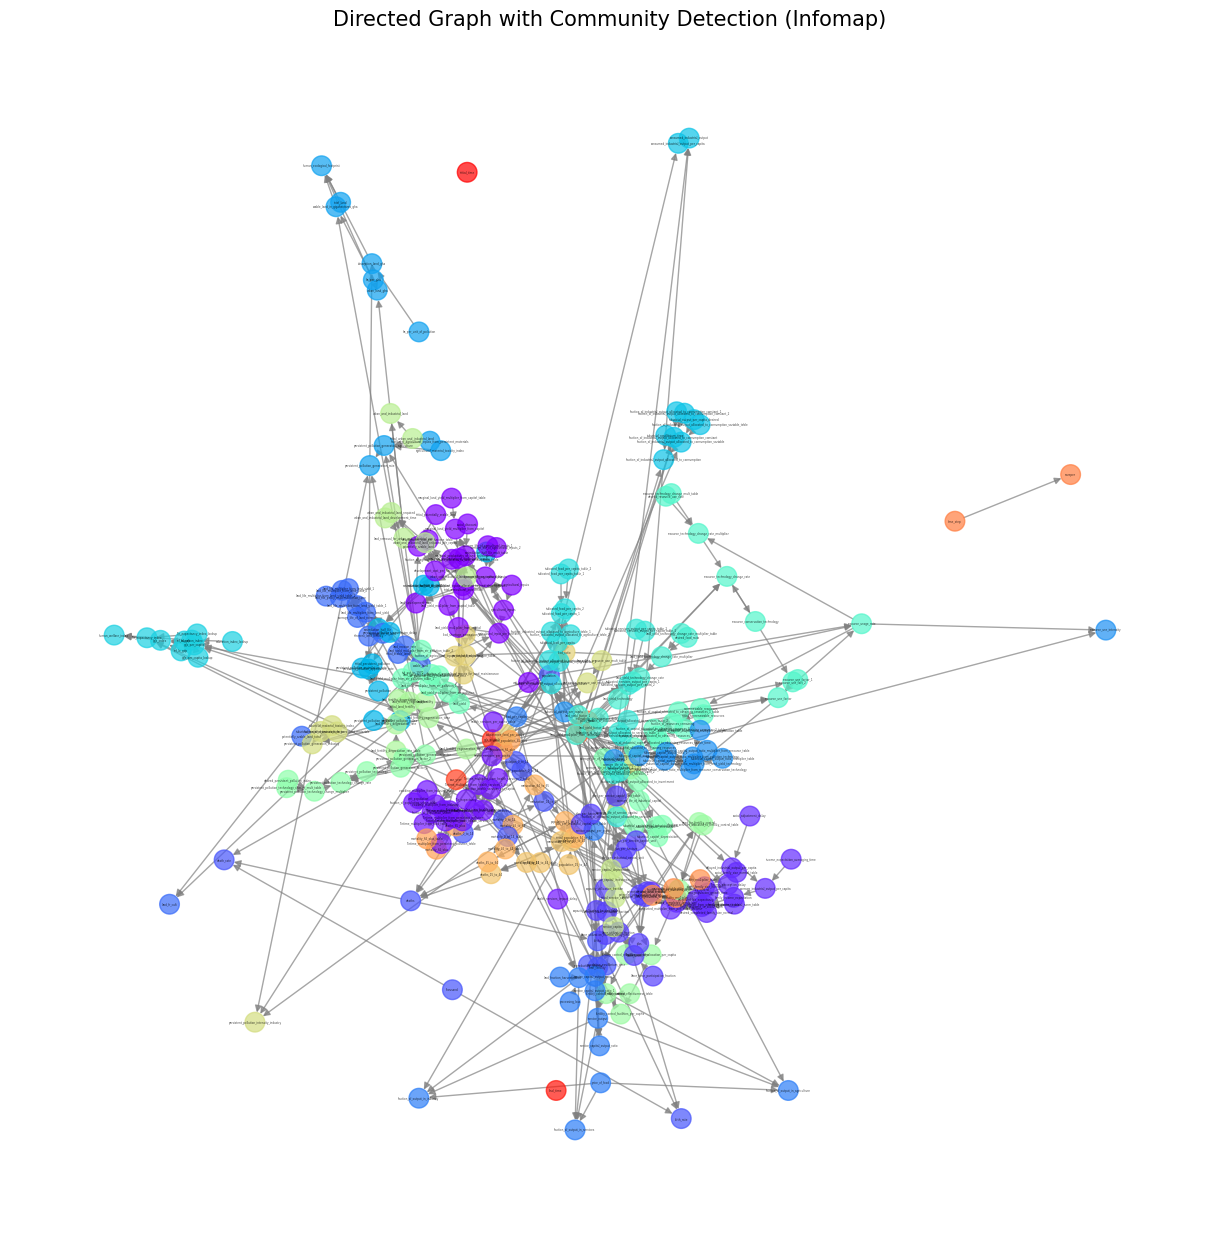

In [ ]:

communities = algorithms.infomap(G)
community_map = {}
for i, comm in enumerate(communities.communities):
    for node in comm:
        community_map[node] = i

# Prepare node colors based on community
node_colors = [community_map[node] for node in G.nodes()]

# Create a list of unique community IDs and their colors
unique_communities = list(set(node_colors))  # Get unique community colors
community_labels = {community: f"Community {community}" for community in unique_communities}
modularity = evaluation.newman_girvan_modularity(G, communities).score
print(f"Modularity: {modularity:.4f}")
# Plot the directed graph with color-coded communities
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # Layout for visualization

# Draw the graph
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=200,
    font_size=2,
    node_color=node_colors,  # Color nodes by community
    cmap=plt.cm.rainbow,  # Colormap to distinguish communities
    edge_color="gray",  # Edge color
    alpha=0.7  # Transparency
)

# Create custom legend handles based on the unique community colors
legend_handles = [Line2D([0], [0], marker='o', color='w', label=community_labels[community],
                         markersize=10, markerfacecolor=plt.cm.rainbow(community / len(unique_communities)))
                  for community in unique_communities]

# Add the legend to the plot


# Title for the plot
plt.title("Directed Graph with Community Detection (Infomap)", fontsize=15)

# Show the plot
plt.show()


Printing communities and their nodes

In [109]:
# Print the number of communities
print(f"Number of communities: {len(communities.communities)}")

# Print each community and its nodes
for i, comm in enumerate(communities.communities):
    print(f"\nCommunity {i} ({len(comm)} nodes):")
    for node in comm:
        print(f"  - {node}")

Number of communities: 37

Community 0 (22 nodes):
  - agricultural_input_per_hectare
  - agricultural_inputs
  - average_life_agricultural_inputs
  - current_agricultural_inputs
  - land_development_rate
  - average_life_of_agricultural_inputs_1
  - average_life_of_agricultural_inputs_2
  - fraction_of_agricultural_inputs_allocated_to_land_development
  - total_agricultural_investment
  - development_cost_per_hectare
  - development_cost_per_hectare_table
  - potentially_arable_land
  - marginal_productivity_of_agricultural_inputs
  - marginal_productivity_of_land_development
  - fraction_of_agricultural_inputs_allocated_to_land_development_table
  - initial_potentially_arable_land
  - unit_agricultural_input
  - land_yield_multiplier_from_capital
  - land_yield_multiplier_from_capital_table
  - marginal_land_yield_multiplier_from_capital
  - marginal_land_yield_multiplier_from_capital_table
  - social_discount

Community 1 (21 nodes):
  - crowding_multiplier_from_industry
  - crowdin

Finding and printing the average betweenness centrality of each community in the network.

In [110]:
# Step 1: Compute betweenness centrality
# Step 1: Compute betweenness centrality
betweeness = nx.betweenness_centrality(G, normalized=True)

# Step 2: Group betweenness centrality values by community
community_betweenness = defaultdict(list)
for node, centrality in betweeness.items():
    community_id = community_map[node]
    community_betweenness[community_id].append(centrality)

# Step 3: Compute average betweenness for each community
avg_bc_per_community = {
    community_id: sum(values) / len(values)
    for community_id, values in community_betweenness.items()
}

# Step 4: Sort communities by average betweenness (descending)
sorted_avg_bc = sorted(avg_bc_per_community.items(), key=lambda x: x[1], reverse=True)

# Step 5: Print sorted results
print("\nAverage Betweenness Centrality per Community (Sorted):")
for rank, (community_id, avg_bc) in enumerate(sorted_avg_bc, start=1):
    print(f"{rank}. Community {community_id}: Average Betweenness = {avg_bc:.6f}")
    



Average Betweenness Centrality per Community (Sorted):
1. Community 7: Average Betweenness = 0.035659
2. Community 4: Average Betweenness = 0.027693
3. Community 6: Average Betweenness = 0.020663
4. Community 18: Average Betweenness = 0.020368
5. Community 9: Average Betweenness = 0.018415
6. Community 3: Average Betweenness = 0.018312
7. Community 26: Average Betweenness = 0.015884
8. Community 1: Average Betweenness = 0.015501
9. Community 17: Average Betweenness = 0.015323
10. Community 27: Average Betweenness = 0.014656
11. Community 15: Average Betweenness = 0.014622
12. Community 19: Average Betweenness = 0.011111
13. Community 22: Average Betweenness = 0.010713
14. Community 5: Average Betweenness = 0.010630
15. Community 0: Average Betweenness = 0.010405
16. Community 25: Average Betweenness = 0.010105
17. Community 14: Average Betweenness = 0.010016
18. Community 24: Average Betweenness = 0.009904
19. Community 28: Average Betweenness = 0.009015
20. Community 20: Average Betw

Plotting the betweenness centrality (size) and the community (colour) of each node in the world3 network.

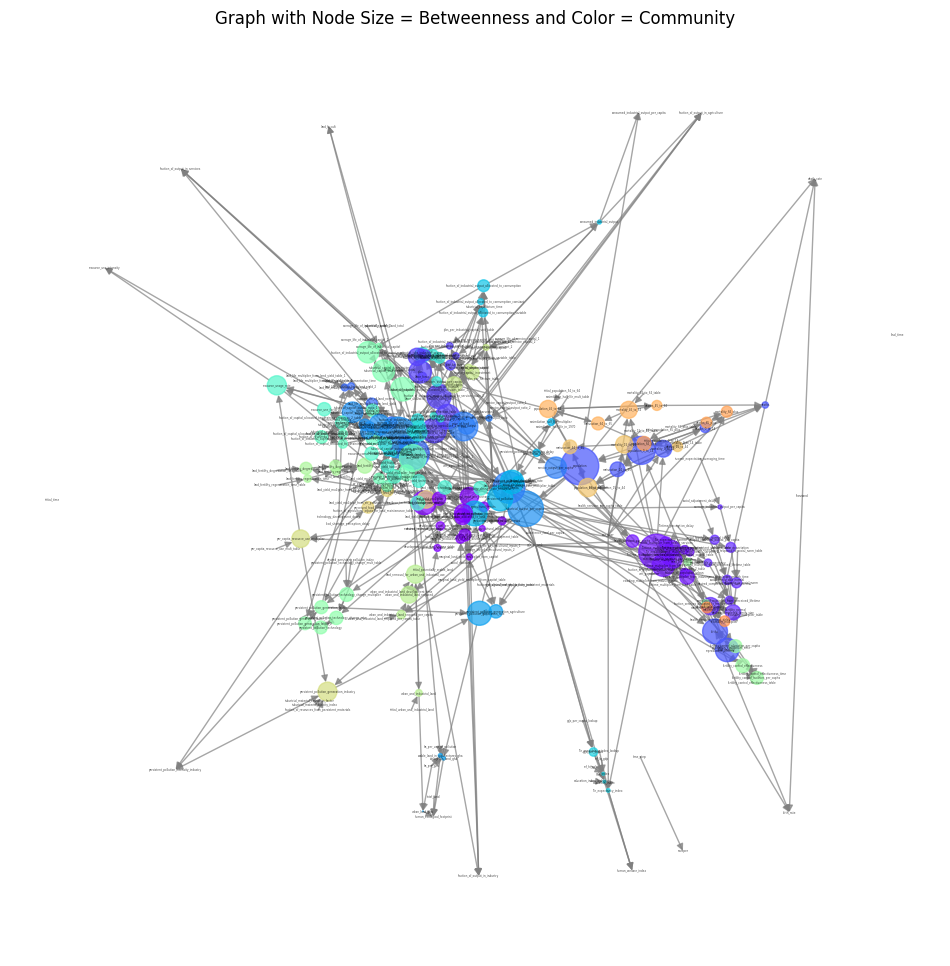

In [111]:
betweenness = nx.betweenness_centrality(G, normalized=True)

# Get layout for consistent plotting
pos = nx.spring_layout(G, seed=42)

# Node colors = community ID
node_colors = [community_map[n] for n in G.nodes()]

# Node sizes = betweenness centrality (scaled up for visibility)
node_sizes = [5000 * betweenness[n] for n in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    G,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    with_labels=True,
    font_size=2,
    edge_color="gray",
    cmap=plt.cm.rainbow,
    alpha=0.7
)

plt.title("Graph with Node Size = Betweenness and Color = Community")
plt.axis("off")
plt.show()